In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-06-02 11:43:15.988609: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-02 11:43:16.010337: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-02 11:43:16.037039: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-02 11:43:16.037190: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8169557948605270026
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5465309184
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7805407112471466218
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:2b:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [3]:
# import sys
# log_path = 'log.txt'
# sys.stdout = open(log_path, "w")

import h5py
# h5 = h5py.File('./reformattedData_20220531/All_cases_100x100_per500.hdf5', mode='r')
h5 = h5py.File('./reformattedData_20220523/ConvLSTM_all_cases_200x200_per1000_previousPhi_tipTheta_35_compressed.hdf5', mode='r')
dataset = h5.get('phi')

# # Split into train and validation sets using indexing to optimize memory.
data_sz = dataset.shape[0]
indexes = np.arange(data_sz)
np.random.shuffle(indexes)
train_index = np.sort(indexes[: int(0.75 * data_sz)])
val_index = np.sort(indexes[int(0.75 * data_sz) :])
print(train_index)
print(val_index)

[ 0  1  2  3  4  5  6  7  8  9 13 14 15 16 19 23 24 26 27 29 30 31 34 35
 36 37 39 41 42 43 45 46 47 48 49 50 51 52 53 55 58 59 60 61 62 63 66 67
 68 69 71 72 73 74 75 76 77 78 79 80 81 82]
[10 11 12 17 18 20 21 22 25 28 32 33 38 40 44 54 56 57 64 65 70]


In [4]:
# this part is a bit slow
train_dataset = dataset[train_index,...]
val_dataset = dataset[val_index,...]

val_dataset.shape

(21, 35, 200, 200, 2)

In [5]:
# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :, 0]
    y = np.expand_dims(y,4)
    return x, y
    
# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (62, 34, 200, 200, 2), (62, 34, 200, 200, 1)
Validation Dataset Shapes: (21, 34, 200, 200, 2), (21, 34, 200, 200, 1)


Displaying frames for example 36.


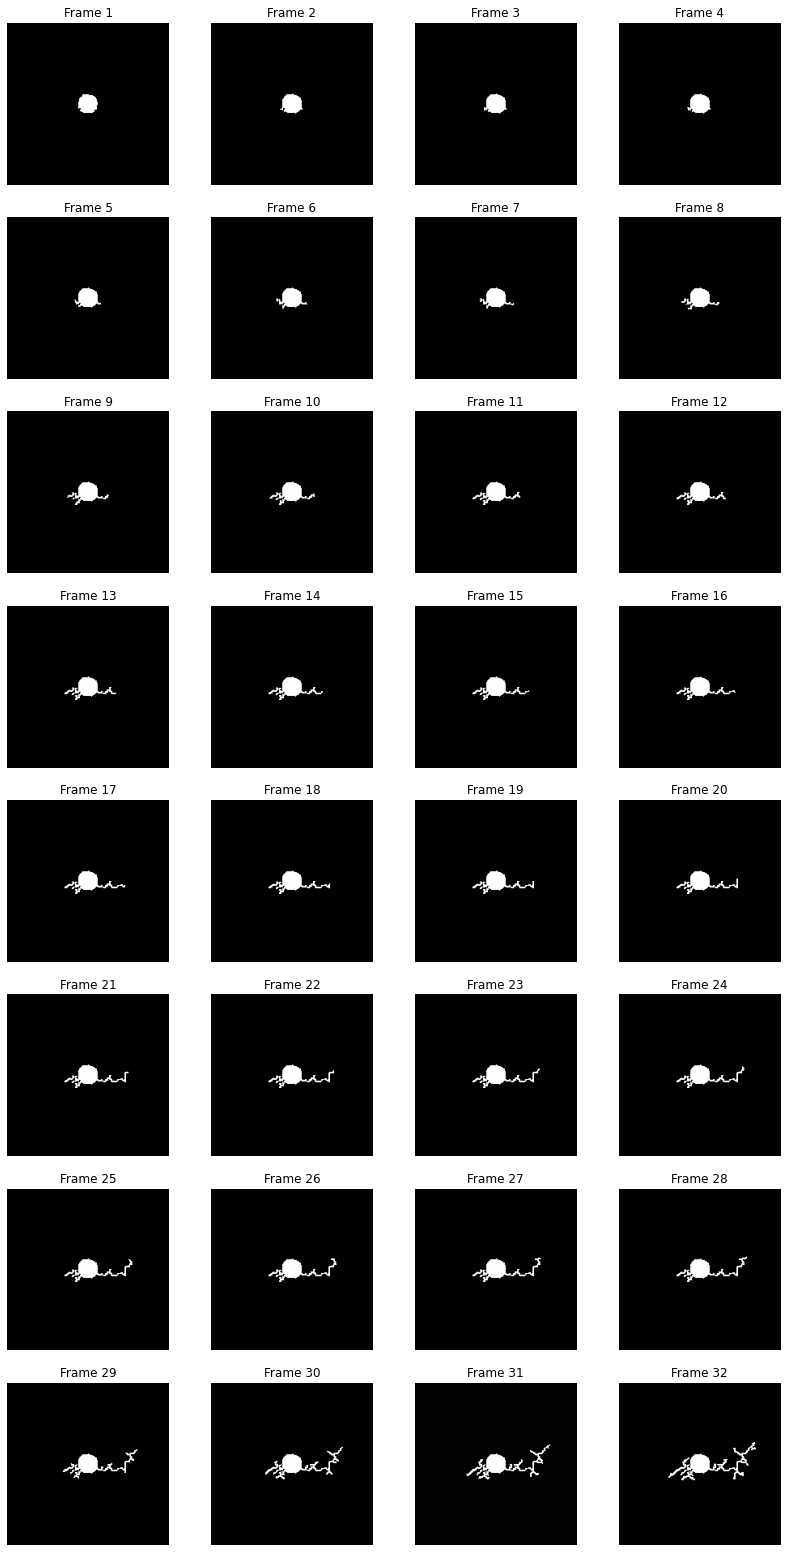

In [6]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(8, 4, figsize=(14, 28))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(x_train)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(x_train[data_choice][idx][:,:,0]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

Displaying frames for example 36.


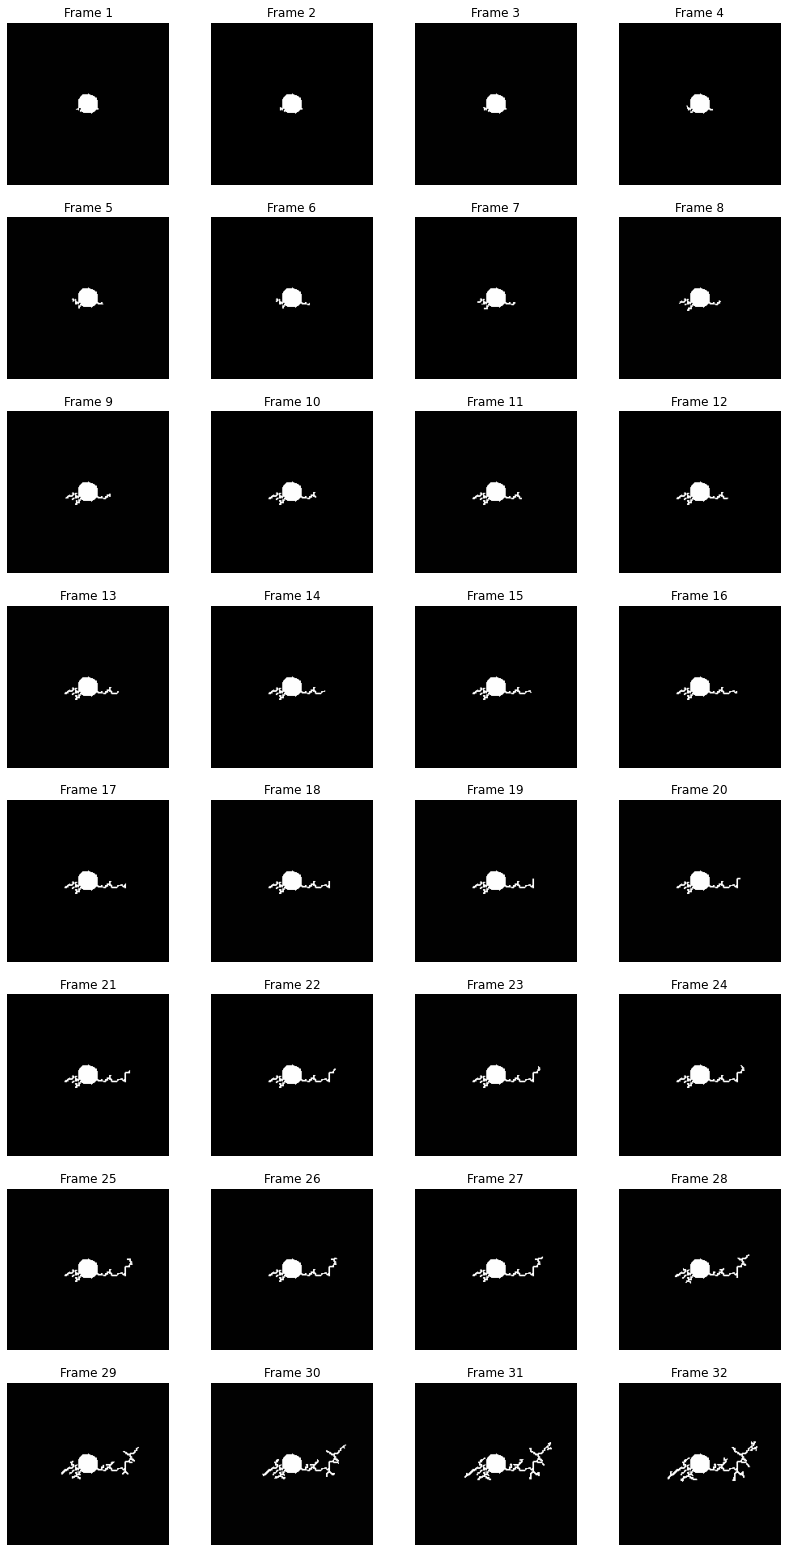

In [7]:
fig, axes = plt.subplots(8, 4, figsize=(14, 28))

for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(y_train[data_choice][idx][:,:,0]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

In [8]:
# # Construct the input layer with no definite frame size.
# inp = layers.Input(shape=(None, *x_train.shape[2:]))

# x0 = layers.ConvLSTM2D(
#     filters=64,
#     kernel_size=(5, 5),
#     strides = (2, 2),
#     padding="valid",
#     return_sequences=True,
#     activation="relu",
# )(inp)
# x1 = layers.ConvLSTM2D(
#     filters=128,
#     kernel_size=(5, 5),
#     strides = (2, 2),
#     padding="valid",
#     return_sequences=True,
#     activation="relu",
# )(x0)
# x3 = layers.TimeDistributed(layers.Conv2DTranspose(
#     filters=64,
#     kernel_size=(6, 6),
#     strides = (2, 2),
#     padding="valid",
#     activation="relu",
# ))(x1)
# x4 = layers.TimeDistributed(layers.Conv2DTranspose(
#     filters=1,
#     kernel_size=(6, 6),
#     strides = (2, 2),
#     padding="valid",
#     activation="relu",
# ))(x3)
# x6 = layers.Conv3D(
#     filters=1, kernel_size=(5, 5, 5), activation="sigmoid", padding="same"
# )(x4)

In [9]:
# # Construct the input layer with no definite frame size.
# inp = layers.Input(shape=(None, *x_train.shape[2:]))

# x0 = layers.ConvLSTM2D(
#     filters=64,
#     kernel_size=(5, 5),
#     strides = (2, 2),
#     padding="valid",
#     return_sequences=True,
#     activation="relu",
# )(inp)
# x1 = layers.ConvLSTM2D(
#     filters=128,
#     kernel_size=(5, 5),
#     strides = (2, 2),
#     padding="valid",
#     return_sequences=True,
#     activation="relu",
# )(x0)
# x2 = layers.TimeDistributed(layers.Conv2DTranspose(
#     filters=64,
#     kernel_size=(6, 6),
#     strides = (2, 2),
#     padding="valid",
#     activation="relu",
# ))(x1)
# x3 = layers.Concatenate(axis=4)([x0,x2])
# x4 = layers.TimeDistributed(layers.Conv2DTranspose(
#     filters=1,
#     kernel_size=(6, 6),
#     strides = (2, 2),
#     padding="valid",
#     activation="relu",
# ))(x3)


In [10]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

x0 = layers.TimeDistributed(layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides = (2, 2),
    padding="valid",
    activation="relu",
))(inp)
x1 = layers.TimeDistributed(layers.Conv2D(
    filters=128,
    kernel_size=(5, 5),
    strides = (2, 2),
    padding="valid",
    activation="relu",
))(x0)
x2 = layers.ConvLSTM2D(
    filters=128,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x1)
x3 = layers.Concatenate(axis=4)([x1,x2])
x4 = layers.TimeDistributed(layers.Conv2DTranspose(
    filters=64,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="relu",
))(x3)
x5 = layers.Concatenate(axis=4)([x0,x4])
x6 = layers.TimeDistributed(layers.Conv2DTranspose(
    filters=1,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="relu",
))(x5)

2022-06-02 11:44:05.044319: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-02 11:44:05.044576: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-02 11:44:05.044857: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-02 11:44:05.045256: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-02 11:44:05.045454: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [11]:
model = keras.models.Model(inp, x6)
model.compile(
    # loss=keras.losses.BinaryCrossentropy(reduction="auto", name="binary_crossentropy"), optimizer=keras.optimizers.Adam(learning_rate=1e-6),
    loss=keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"), optimizer=keras.optimizers.Adam(learning_rate=1e-6),
    # loss=keras.losses.MeanAbsoluteError(reduction="auto", name="mean_absolute_error"), optimizer=keras.optimizers.Adam(learning_rate=1e-6),
)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 200,   0           []                               
                                200, 2)]                                                          
                                                                                                  
 time_distributed (TimeDistribu  (None, None, 98, 98  3264       ['input_1[0][0]']                
 ted)                           , 64)                                                             
                                                                                                  
 time_distributed_1 (TimeDistri  (None, None, 47, 47  204928     ['time_distributed[0][0]']       
 buted)                         , 128)                                                        

## Model Training

With our model and data constructed, we can now train the model.

In [12]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

epochs = 500
batch_size = 1

# with tf.device('/device:CPU:0'):
with tf.device('/device:GPU:0'):
    model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val, y_val),
        callbacks=[early_stopping, reduce_lr],
    )

2022-06-02 11:44:05.552172: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 674560000 exceeds 10% of free system memory.
2022-06-02 11:44:06.020715: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 674560000 exceeds 10% of free system memory.


Epoch 1/500


2022-06-02 11:44:07.177841: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'Func/gradient_tape/model/conv_lstm2d/while/model/conv_lstm2d/while_grad/body/_189/input/_551' -> 'gradient_tape/model/conv_lstm2d/while/model/conv_lstm2d/while_grad/body/_189/gradient_tape/model/conv_lstm2d/while/gradients/AddN', 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/mul_2' -> 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/add_5', 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/clip_by_value' -> 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/mul_3', 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/clip_by_value_2' -> 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/mul_5', 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/convolution_6' -> 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/add_4'}.
2022-06-02 11

62/62 [==============================] - ETA: 0s - loss: 0.0202

2022-06-02 11:44:24.226264: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/convolution_7' -> 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/add_6', 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/Relu_1' -> 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/mul_5', 'Func/model/conv_lstm2d/while/body/_1/input/_68' -> 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/mul_2'}.


62/62 [==============================] - 19s 265ms/step - loss: 0.0202 - val_loss: 0.0200 - lr: 1.0000e-06
Epoch 2/500
62/62 [==============================] - 16s 259ms/step - loss: 0.0200 - val_loss: 0.0198 - lr: 1.0000e-06
Epoch 3/500
62/62 [==============================] - 16s 259ms/step - loss: 0.0198 - val_loss: 0.0196 - lr: 1.0000e-06
Epoch 4/500
62/62 [==============================] - 16s 258ms/step - loss: 0.0195 - val_loss: 0.0192 - lr: 1.0000e-06
Epoch 5/500
62/62 [==============================] - 16s 258ms/step - loss: 0.0189 - val_loss: 0.0181 - lr: 1.0000e-06
Epoch 6/500
62/62 [==============================] - 16s 261ms/step - loss: 0.0164 - val_loss: 0.0151 - lr: 1.0000e-06
Epoch 7/500
62/62 [==============================] - 16s 262ms/step - loss: 0.0145 - val_loss: 0.0137 - lr: 1.0000e-06
Epoch 8/500
62/62 [==============================] - 16s 256ms/step - loss: 0.0132 - val_loss: 0.0125 - lr: 1.0000e-06
Epoch 9/500
62/62 [==============================] - 15s 247

KeyboardInterrupt: 

In [13]:
model.save('./tmp/model_crossBin350_3')
# loaded_model = tf.keras.models.load_model('/tmp/model')

2022-06-02 12:12:25.728828: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./tmp/model_crossBin350_3/assets


## Frame Prediction Visualizations

With our model now constructed and trained, we can generate
some example frame predictions based on a new video.

We'll pick a random example from the validation set and
then choose the first ten frames from them. From there, we can
allow the model to predict 10 new frames, which we can compare
to the ground truth frame predictions.

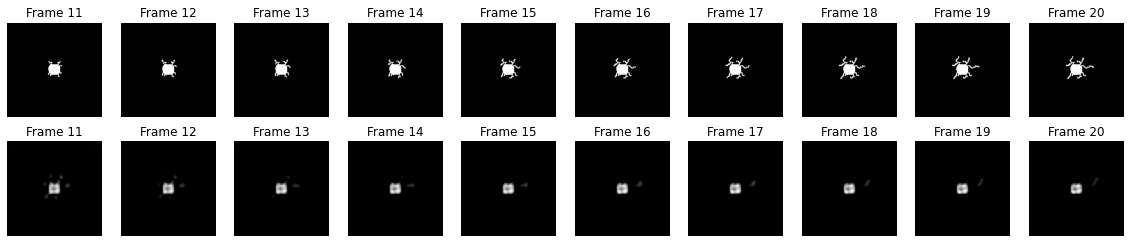

<Figure size 432x288 with 0 Axes>

In [17]:
# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

base_frames = 10
# Pick the first/last ten frames from the example.
frames = example[:base_frames, ...]
original_frames = example[base_frames:, ...]

# Predict a new set of 10 frames.
for i in range(35-base_frames):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    pred_set = np.concatenate((predicted_frame[0,:,:,:], original_frames[i,:,:,1:3]), axis=2)
    frames = np.concatenate((frames, np.expand_dims(pred_set,0)), axis=0)

fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx,:,:,0]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx,:,:,0]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()

plt.savefig('convLSTMresults.png')

In [25]:
# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

base_frames = 3
# Pick the first/last ten frames from the example.
frames = example[:base_frames, ...]
original_frames = example[base_frames:, ...]

# # Pick the first/last ten frames from the example.
# frames = example[:3, ...]
# original_frames = example[3:, ...]

for i in range(example.shape[0]-base_frames):
    new_prediction = model.predict(np.expand_dims(frames[-base_frames:,...], axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
    pred_set = np.concatenate((predicted_frame[0,:,:,:], np.expand_dims(original_frames[i,:,:,1],2)), axis=2)

    frames = np.concatenate((frames, np.expand_dims(pred_set,0)), axis=0)

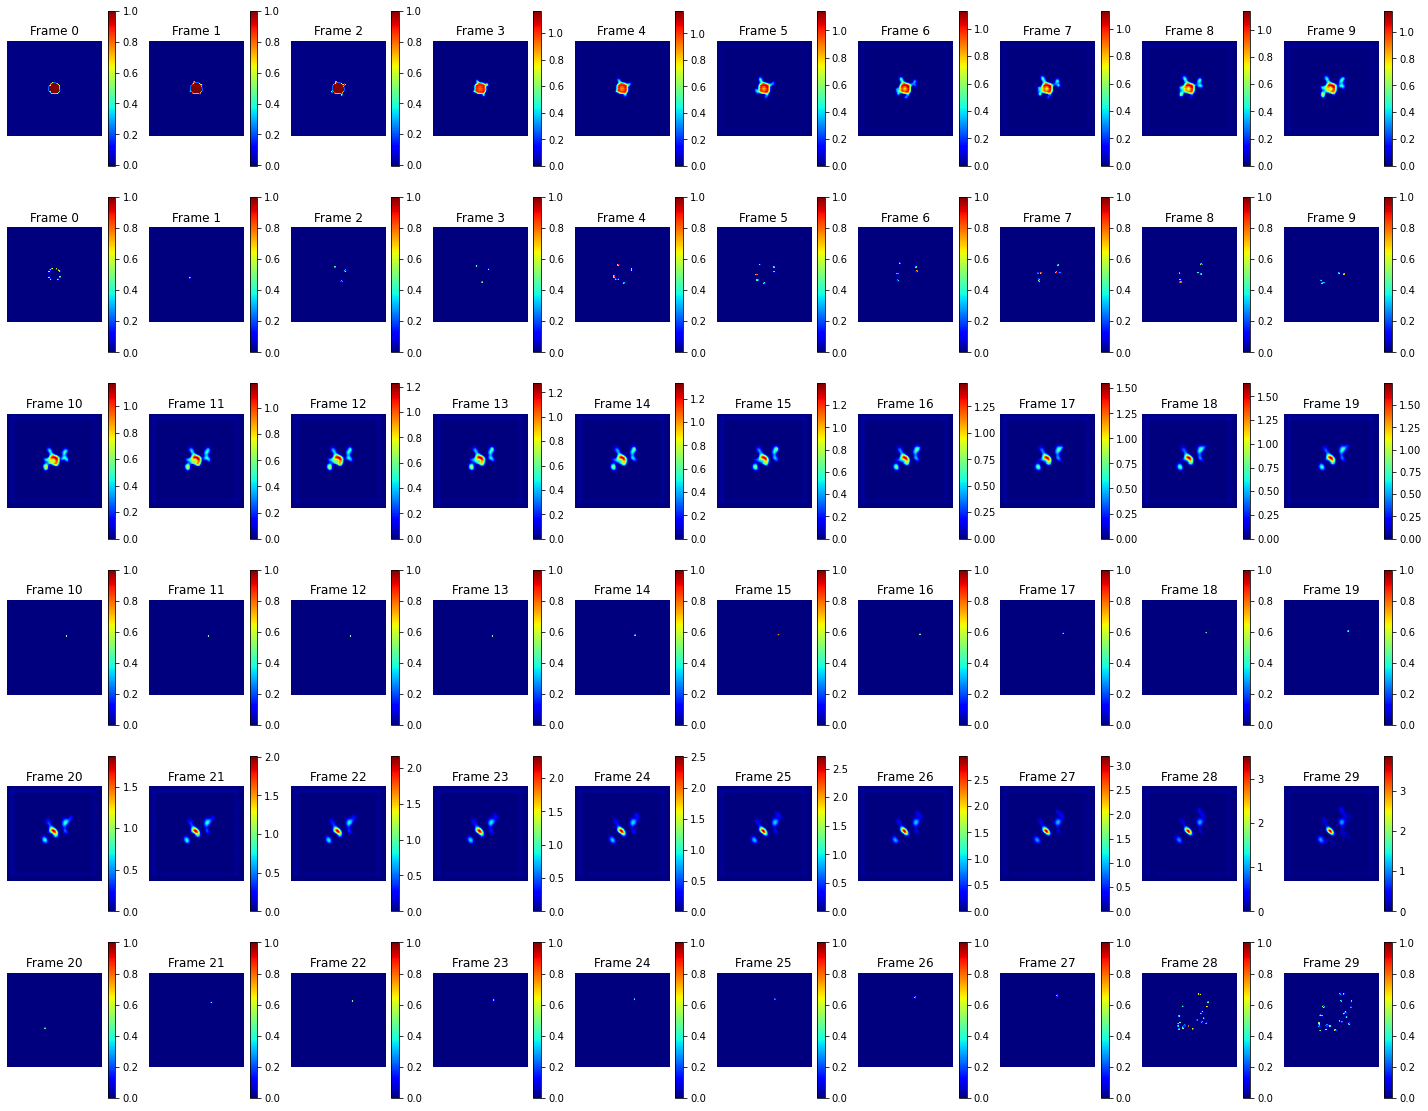

In [26]:
fig, axes = plt.subplots(6, 10, figsize=(25, 20))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    plt.subplot(6,10,idx+1)
    plt.imshow(np.squeeze(frames[idx,:,:,0]), cmap="jet")
    plt.title(f"Frame {idx}")
    plt.axis('off')
    plt.colorbar()
for idx, ax in enumerate(axes[1]):
    plt.subplot(6,10,idx+11)
    plt.imshow(np.squeeze(frames[idx,:,:,1]), cmap="jet")
    plt.title(f"Frame {idx}")
    plt.axis('off')
    plt.colorbar()
for idx, ax in enumerate(axes[2]):
    plt.subplot(6,10,idx+21)
    plt.imshow(np.squeeze(frames[idx+10,:,:,0]), cmap="jet")
    plt.title(f"Frame {idx+10}")
    plt.axis('off')
    plt.colorbar()
for idx, ax in enumerate(axes[3]):
    plt.subplot(6,10,idx+31)
    plt.imshow(np.squeeze(frames[idx+10,:,:,1]), cmap="jet")
    plt.title(f"Frame {idx+10}")
    plt.axis('off')
    plt.colorbar()

for idx, ax in enumerate(axes[4]):
    plt.subplot(6,10,idx+41)
    plt.imshow(np.squeeze(frames[idx+20,:,:,0]), cmap="jet")
    plt.title(f"Frame {idx+20}")
    plt.axis('off')
    plt.colorbar()
for idx, ax in enumerate(axes[5]):
    plt.subplot(6,10,idx+51)
    plt.imshow(np.squeeze(frames[idx+20,:,:,1]), cmap="jet")
    plt.title(f"Frame {idx+20}")
    plt.axis('off')
    plt.colorbar()
# for idx, ax in enumerate(axes[6]):
#     plt.subplot(10,10,idx+61)
#     plt.imshow(np.squeeze(frames[idx+30,:,:,0]), cmap="jet")
#     plt.title(f"Frame {idx+30}")
#     plt.axis('off')
#     plt.colorbar()
# for idx, ax in enumerate(axes[7]):
#     plt.subplot(10,10,idx+71)
#     plt.imshow(np.squeeze(frames[idx+30,:,:,1]), cmap="jet")
#     plt.title(f"Frame {idx+30}")
#     plt.axis('off')
#     plt.colorbar()
# for idx, ax in enumerate(axes[8]):
#     plt.subplot(10,10,idx+81)
#     plt.imshow(np.squeeze(frames[idx+40,:,:,0]), cmap="jet")
#     plt.title(f"Frame {idx+40}")
#     plt.axis('off')
#     plt.colorbar()
# for idx, ax in enumerate(axes[9]):
#     plt.subplot(10,10,idx+91)
#     plt.imshow(np.squeeze(frames[idx+40,:,:,1]), cmap="jet")
#     plt.title(f"Frame {idx+50}")
#     plt.axis('off')
#     plt.colorbar()

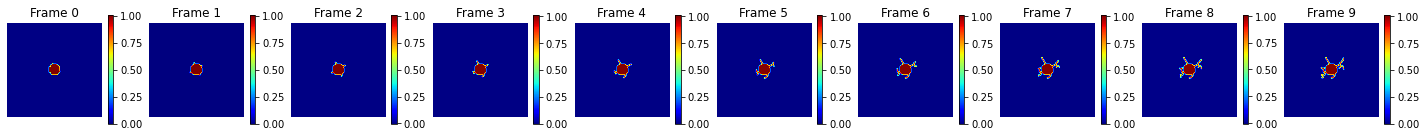

In [27]:
fig, axes = plt.subplots(2, 10, figsize=(25, 2))

for idx, ax in enumerate(axes[0]):
    plt.subplot(1,10,idx+1)
    plt.imshow(np.squeeze(example[idx,:,:,0]), cmap="jet")
    plt.title(f"Frame {idx}")
    plt.axis('off')
    plt.colorbar()

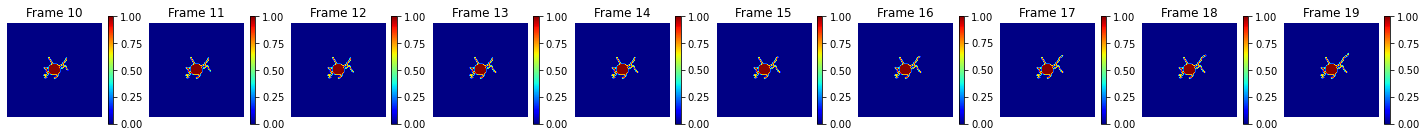

In [28]:
fig, axes = plt.subplots(2, 10, figsize=(25, 2))

for idx, ax in enumerate(axes[0]):
    plt.subplot(1,10,idx+1)
    plt.imshow(np.squeeze(example[idx+10,:,:,0]), cmap="jet")
    plt.title(f"Frame {idx+10}")
    plt.axis('off')
    plt.colorbar()

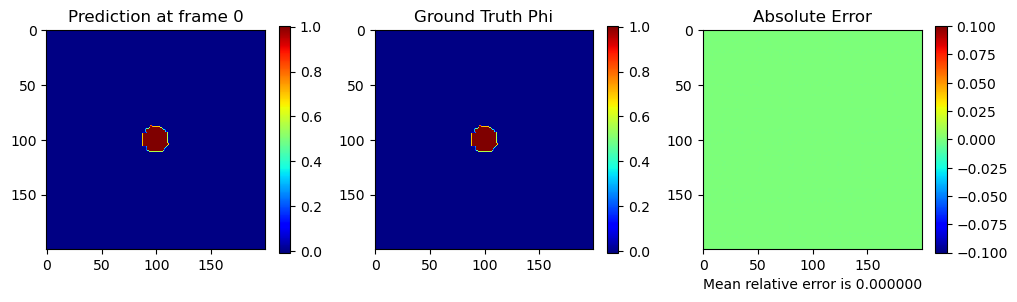

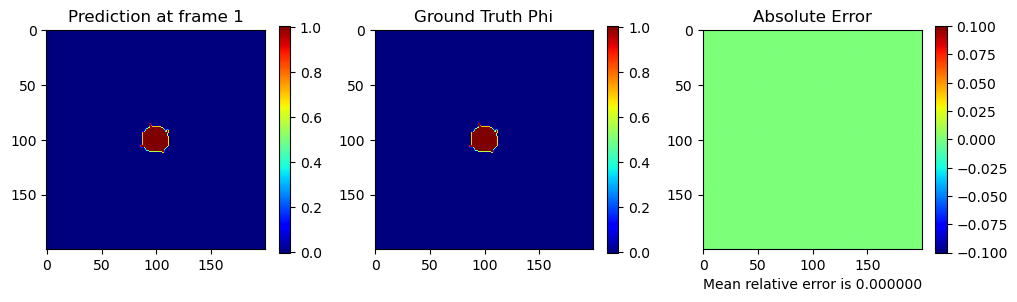

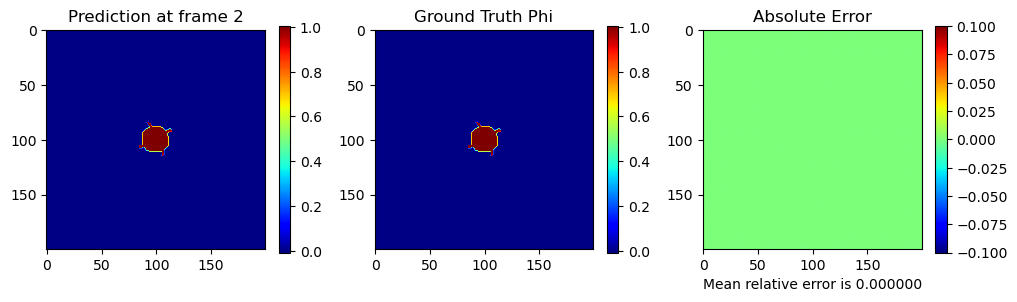

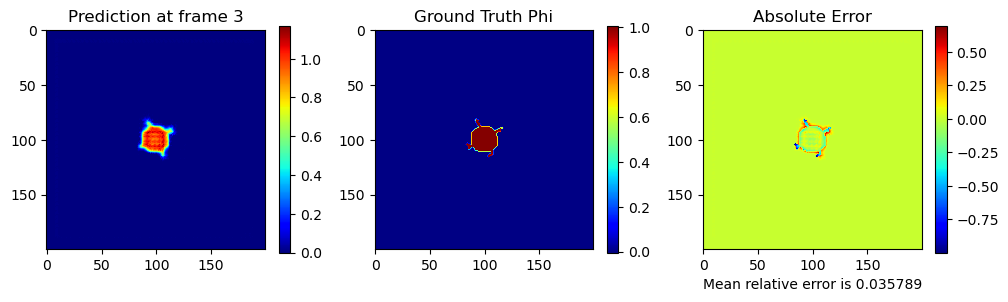

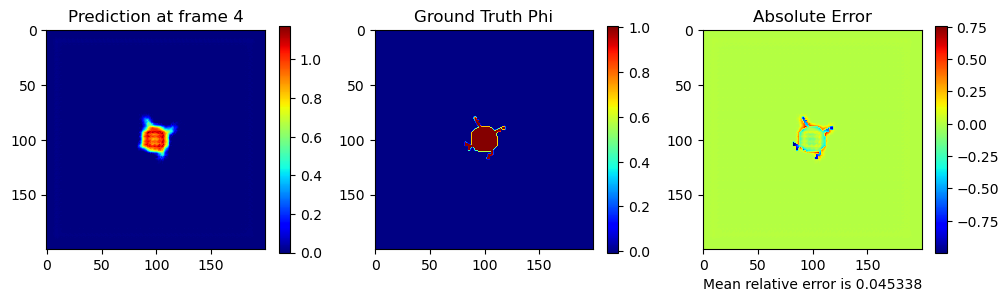

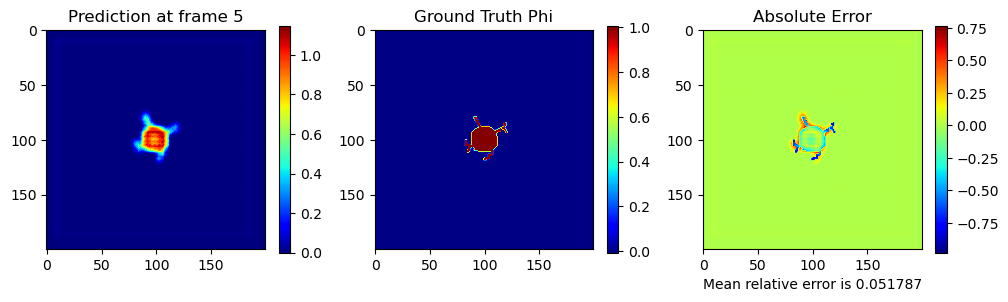

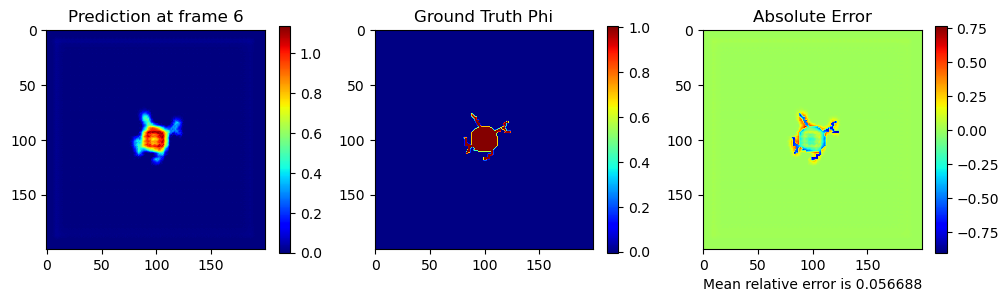

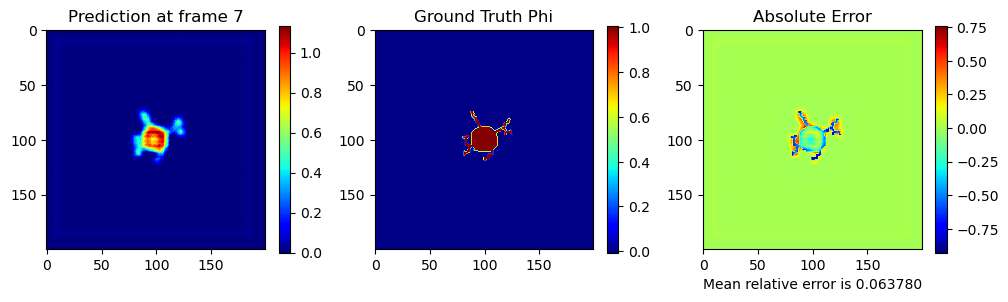

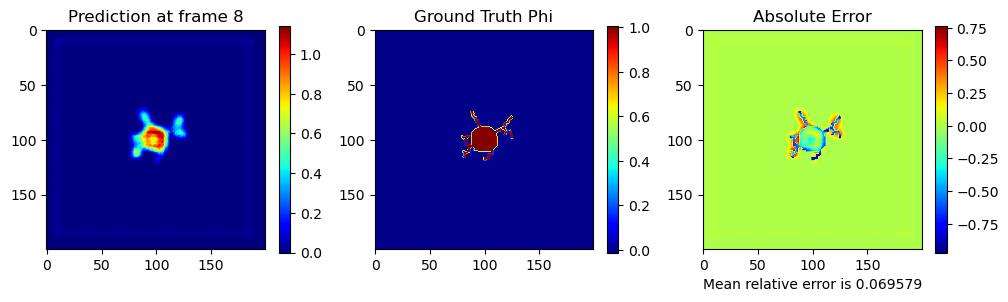

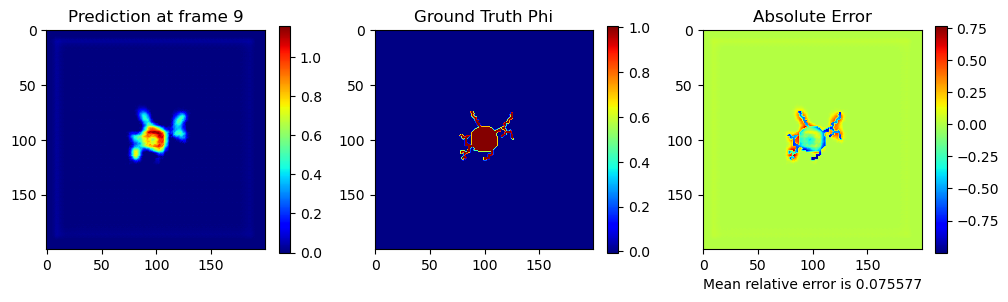

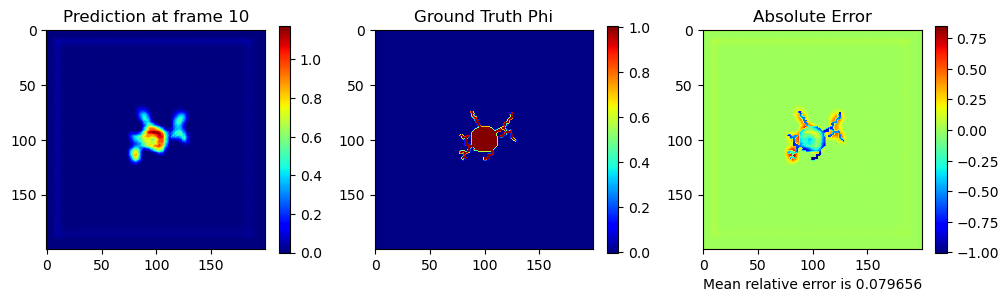

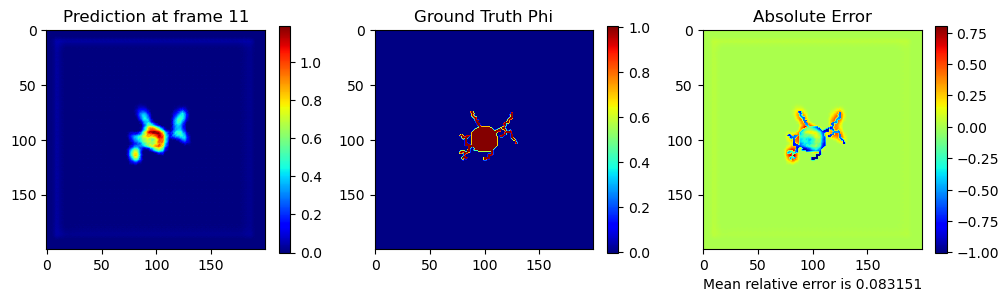

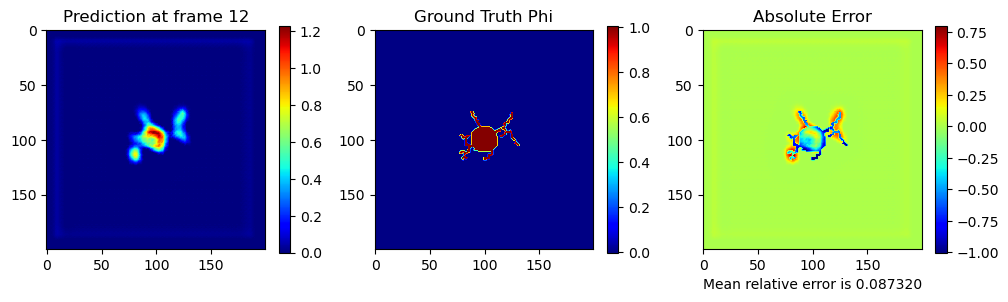

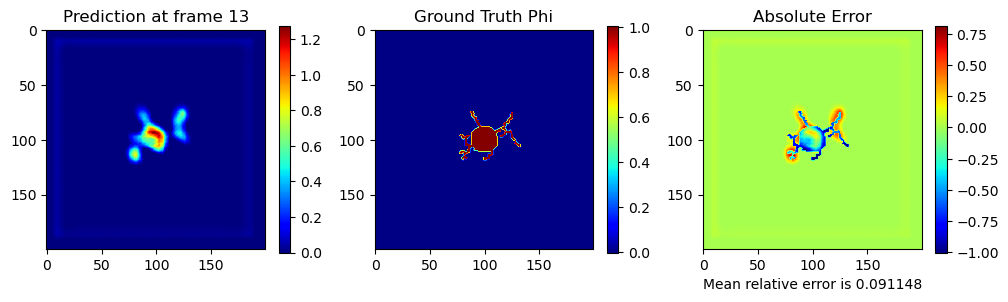

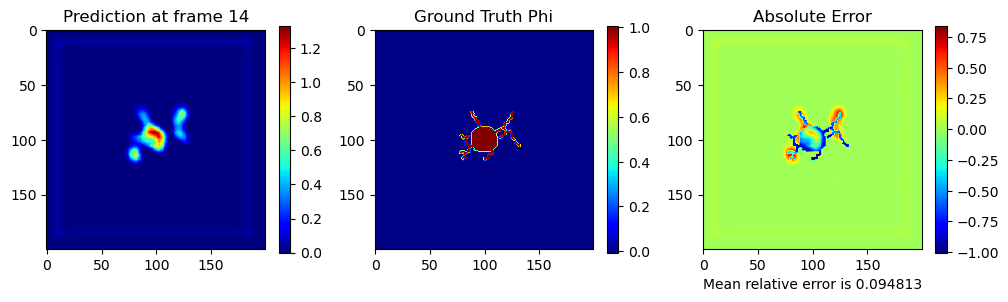

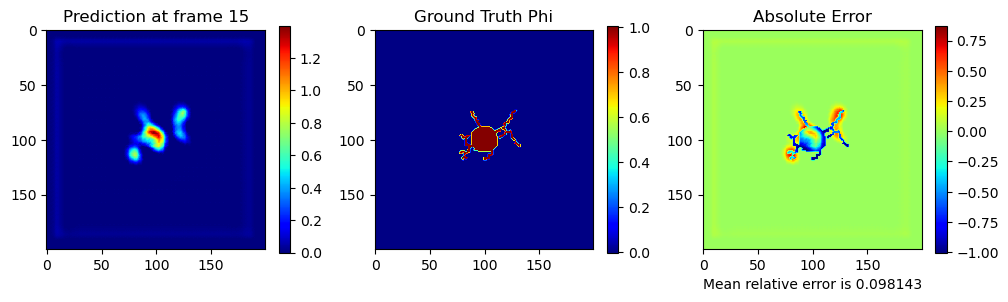

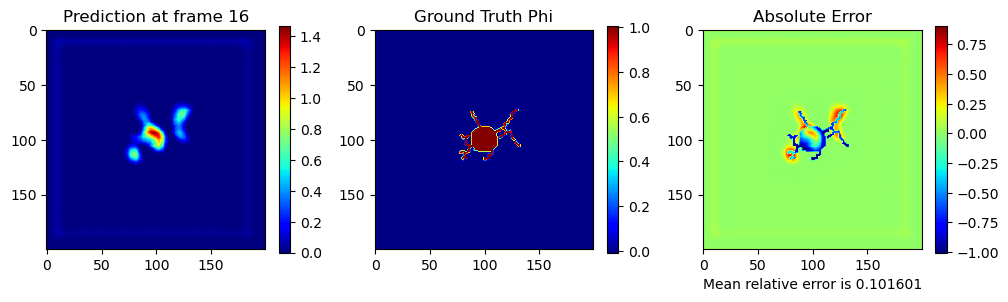

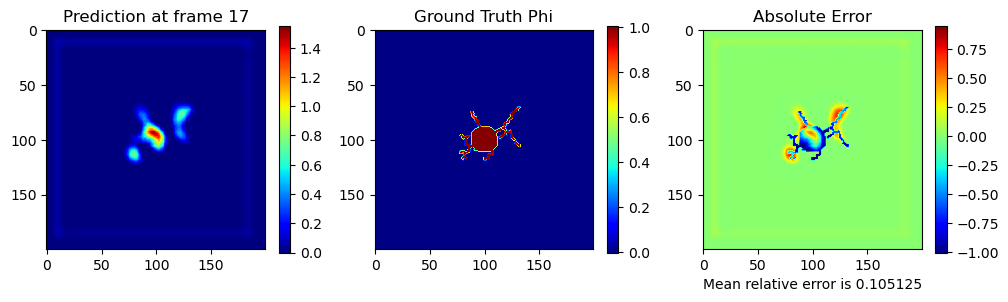

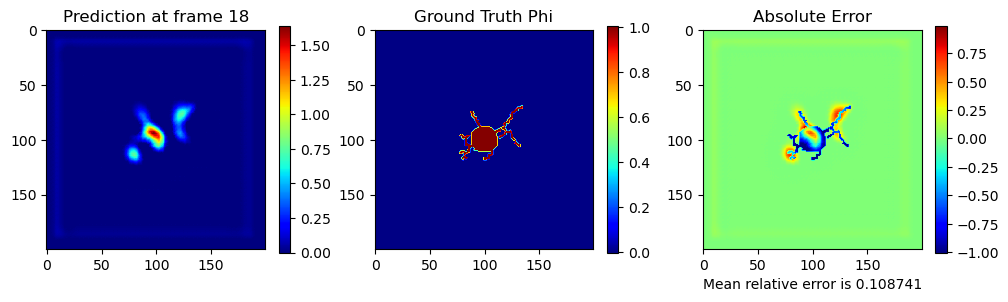

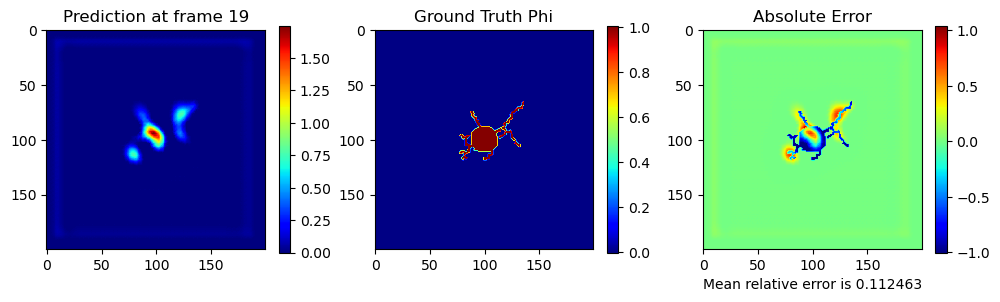

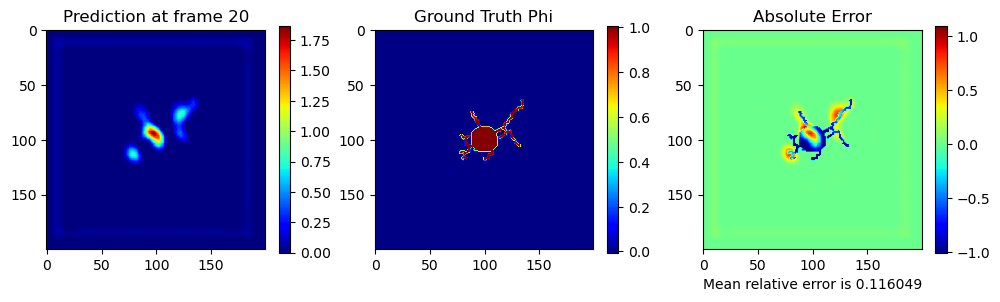

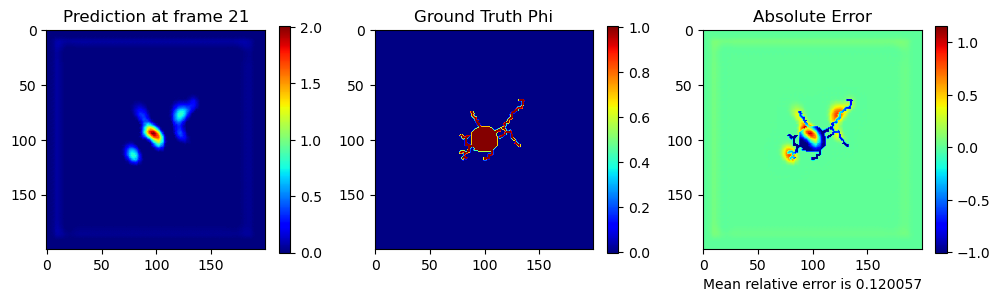

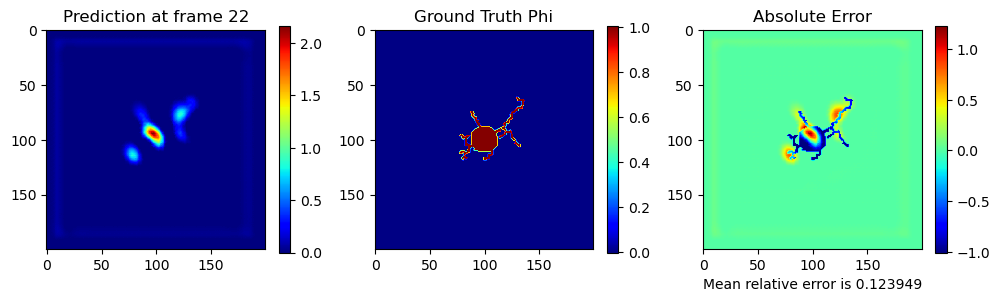

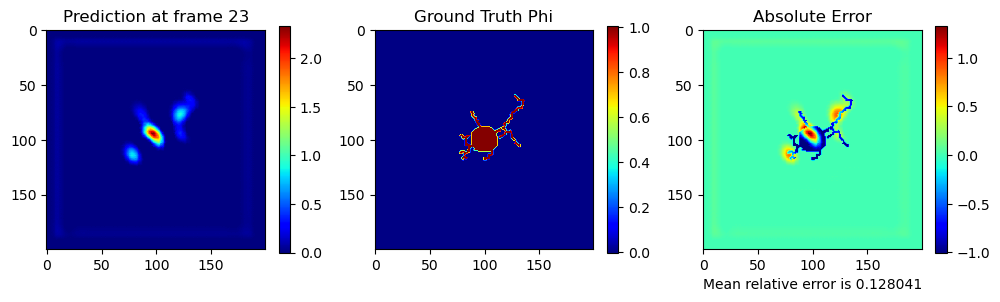

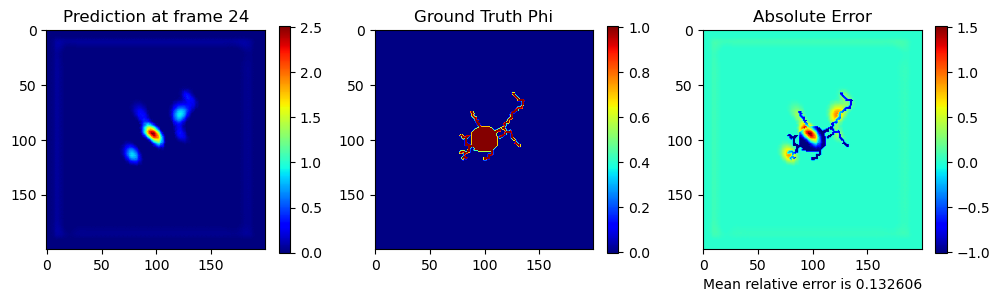

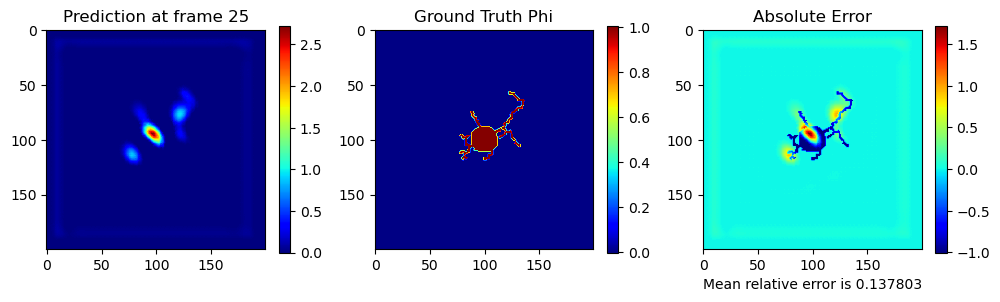

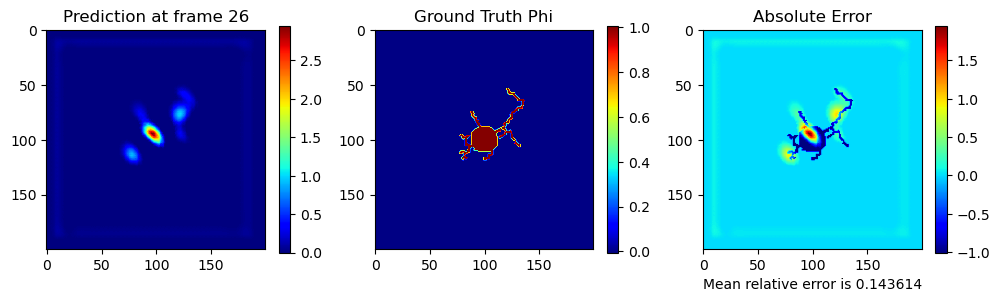

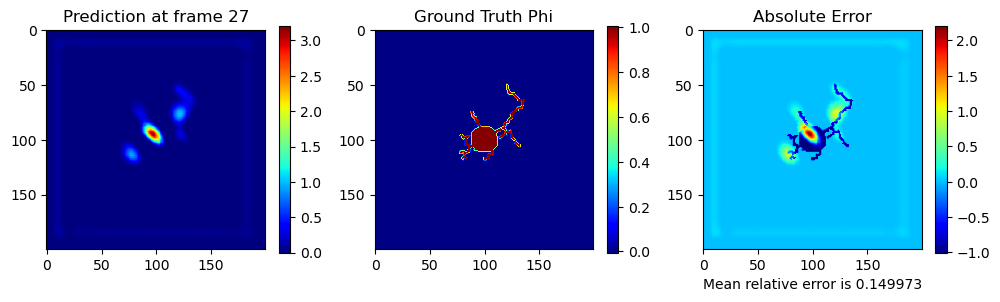

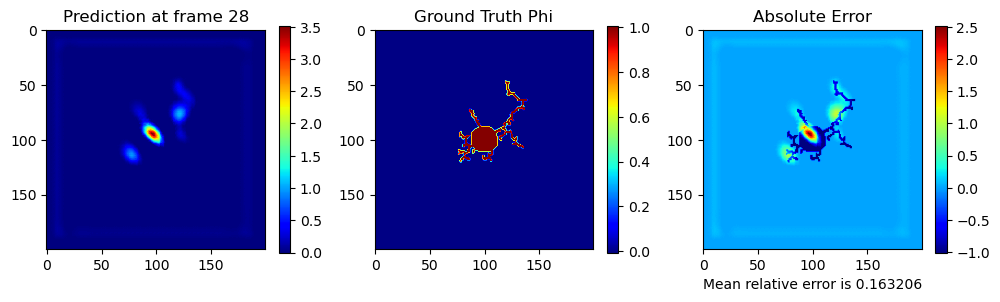

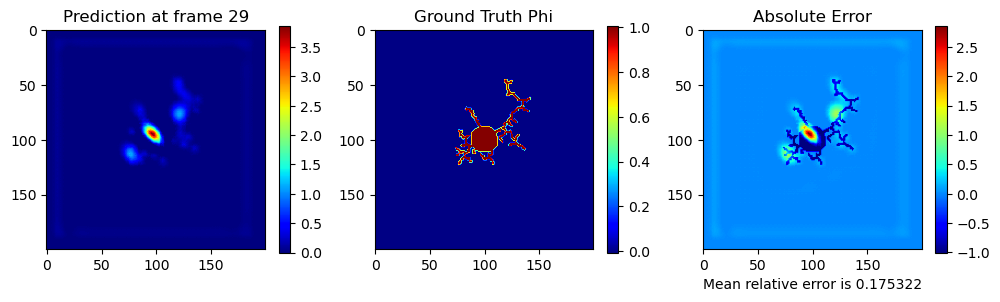

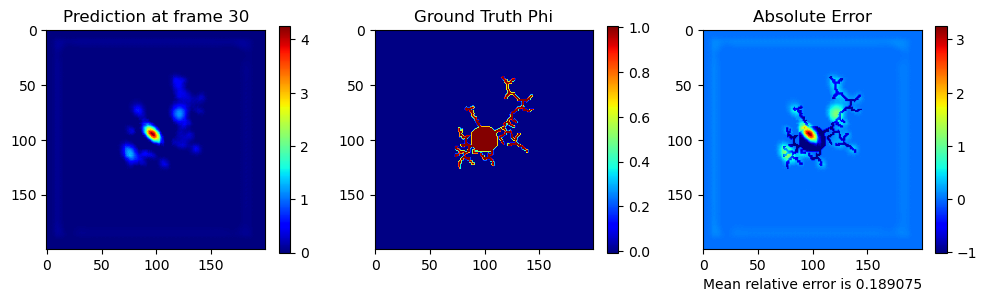

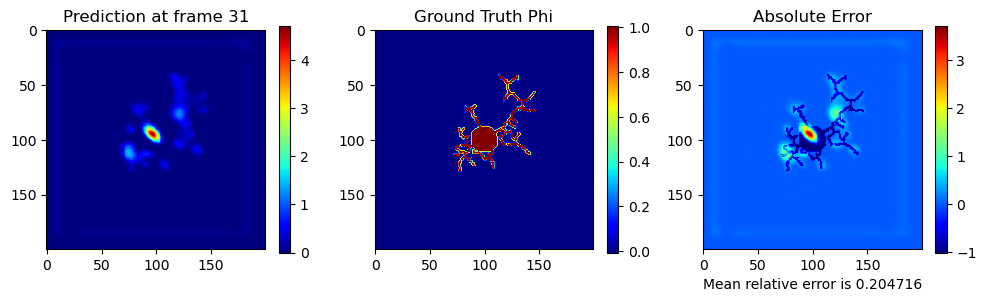

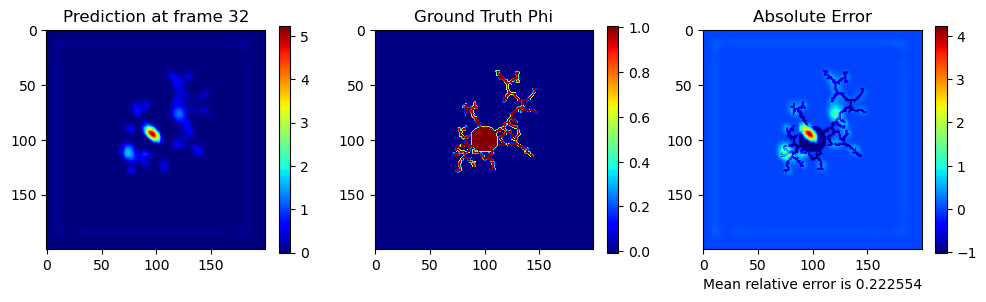

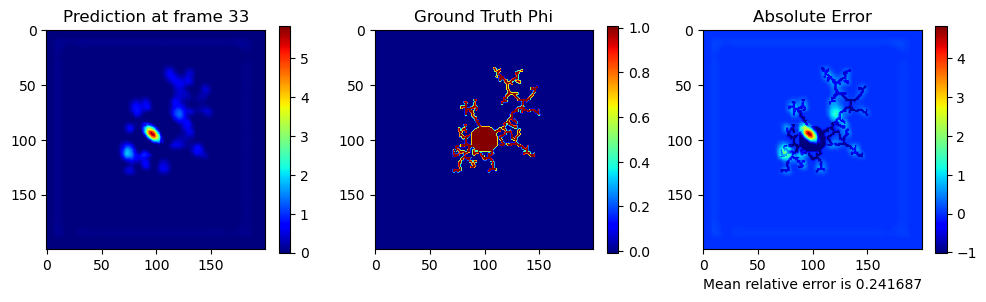

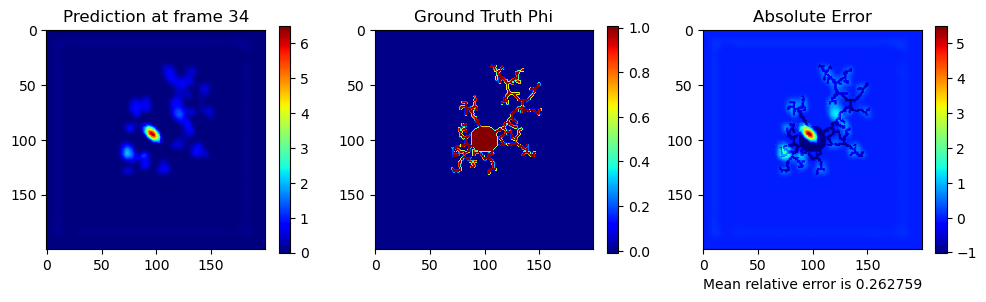

In [39]:
for i in range(35):
    plt.figure(figsize=(12,3), dpi=100)

    mean_relative_error = np.sqrt(np.sum(np.square(frames[i,:,:,0]-example[i,:,:,0]))/(200*200))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(frames[i,:,:,0]), cmap="jet")
    plt.title('Prediction at frame %d'%i)
    plt.colorbar()
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(example[i,:,:,0]), cmap="jet")
    plt.title('Ground Truth Phi')
    plt.colorbar()
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(frames[i,:,:,0]-example[i,:,:,0]), cmap="jet")
    plt.title('Absolute Error')
    plt.xlabel('Mean relative error is %f'%mean_relative_error)
    plt.colorbar()

    plt.show()
